<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_DenseNet201_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 17 17:46:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   40C    P0    54W / 165W |      9MiB / 24258MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6241221940144897
GPU (s):
0.03091773798223585
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.densenet.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.densenet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 38s 74ms/step - loss: 0.6003 - accuracy: 0.7461 - val_loss: 0.4827 - val_accuracy: 0.8003
Epoch 2/100
360/360 [==============================] - 22s 60ms/step - loss: 0.4921 - accuracy: 0.7874 - val_loss: 0.4658 - val_accuracy: 0.8013
Epoch 3/100
360/360 [==============================] - 22s 60ms/step - loss: 0.4777 - accuracy: 0.7978 - val_loss: 0.4484 - val_accuracy: 0.8039
Epoch 4/100
360/360 [==============================] - 21s 59ms/step - loss: 0.4668 - accuracy: 0.8005 - val_loss: 0.4204 - val_accuracy: 0.8196
Epoch 5/100
360/360 [==============================] - 22s 61ms/step - loss: 0.4475 - accuracy: 0.8092 - val_loss: 0.4103 - val_accuracy: 0.8268
Epoch 6/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4396 -

Epoch 56/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3290 - accuracy: 0.8631 - val_loss: 0.3475 - val_accuracy: 0.8576
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3266 - accuracy: 0.8642 - val_loss: 0.3571 - val_accuracy: 0.8534
Epoch 58/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3334 - accuracy: 0.8612 - val_loss: 0.3497 - val_accuracy: 0.8626
Epoch 59/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3235 - accuracy: 0.8657 - val_loss: 0.3412 - val_accuracy: 0.8638
Epoch 60/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3230 - accuracy: 0.8663 - val_loss: 0.3638 - val_accuracy: 0.8536
Epoch 61/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3198 - accuracy: 0.8675 - val_loss: 0.3596 - val_accuracy: 0.8562
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3272 - accuracy: 0.8676 - val_loss: 0.3815 -

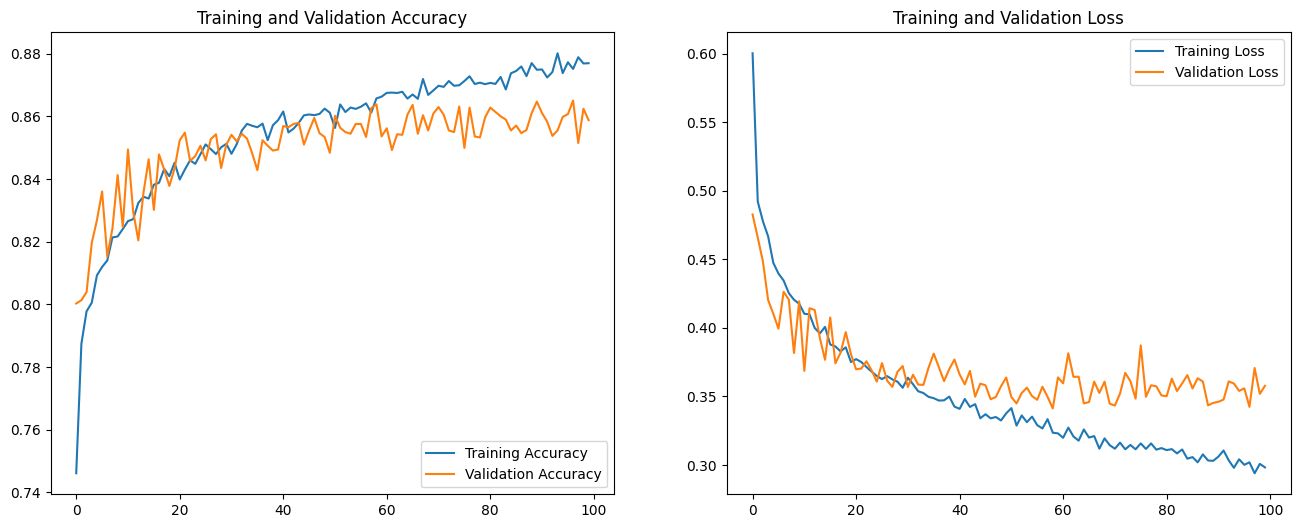

In [5]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 34s 66ms/step - loss: 0.6854 - accuracy: 0.7036 - val_loss: 0.5533 - val_accuracy: 0.7652
Epoch 2/100
360/360 [==============================] - 21s 57ms/step - loss: 0.5824 - accuracy: 0.7535 - val_loss: 0.5396 - val_accuracy: 0.7768
Epoch 3/100
360/360 [==============================] - 21s 57ms/step - loss: 0.5506 - accuracy: 0.7686 - val_loss: 0.5069 - val_accuracy: 0.7860
Epoch 4/100
360/360 [==============================] - 21s 57ms/step - loss: 0.5367 - accuracy: 0.7718 - val_loss: 0.5135 - val_accuracy: 0.7801
Epoch 5/100
360/360 [==============================] - 21s 58ms/step - loss: 0.5237 - accuracy: 0.7773 - val_loss: 0.4960 - val_accuracy: 0.7975
Epoch 6/100
360/360 [==============================] - 21s 57ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 20s 57ms/step - loss: 0.4094 - accuracy: 0.8287 - val_loss: 0.4205 - val_accuracy: 0.8307
Epoch 57/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4092 - accuracy: 0.8260 - val_loss: 0.4495 - val_accuracy: 0.8124
Epoch 58/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4071 - accuracy: 0.8284 - val_loss: 0.4364 - val_accuracy: 0.8248
Epoch 59/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4052 - accuracy: 0.8329 - val_loss: 0.4288 - val_accuracy: 0.8235
Epoch 60/100
360/360 [==============================] - 21s 58ms/step - loss: 0.4058 - accuracy: 0.8309 - val_loss: 0.4179 - val_accuracy: 0.8312
Epoch 61/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4011 - accuracy: 0.8334 - val_loss: 0.4207 - val_accuracy: 0.8307
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4063 - accuracy: 0.8325 - val_loss: 0.4394 -

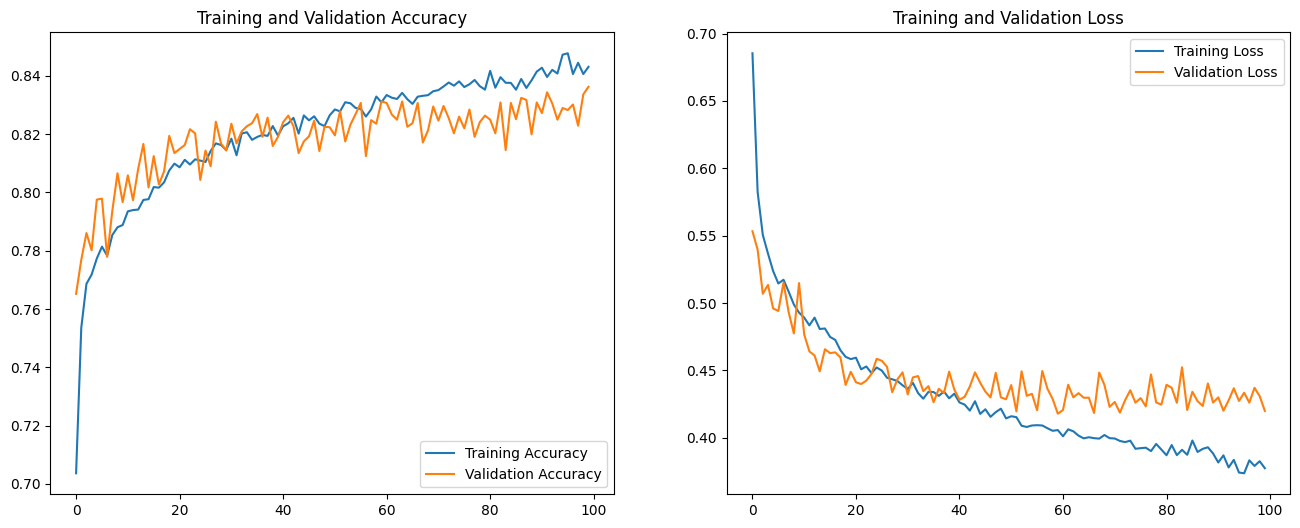

In [6]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 34s 65ms/step - loss: 0.9181 - accuracy: 0.6356 - val_loss: 0.6740 - val_accuracy: 0.7121
Epoch 2/100
360/360 [==============================] - 21s 58ms/step - loss: 0.7107 - accuracy: 0.6926 - val_loss: 0.6356 - val_accuracy: 0.7287
Epoch 3/100
360/360 [==============================] - 21s 58ms/step - loss: 0.6775 - accuracy: 0.7113 - val_loss: 0.6708 - val_accuracy: 0.7041
Epoch 4/100
360/360 [==============================] - 23s 63ms/step - loss: 0.6455 - accuracy: 0.7239 - val_loss: 0.6425 - val_accuracy: 0.7329
Epoch 5/100
360/360 [==============================] - 21s 57ms/step - loss: 0.6314 - accuracy: 0.7338 - val_loss: 0.6047 - val_accuracy: 0.7518
Epoch 6/100
360/360 [==============================] - 21s 58ms/step - loss: 0.6114 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 20s 57ms/step - loss: 0.4800 - accuracy: 0.8091 - val_loss: 0.4882 - val_accuracy: 0.8058
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4807 - accuracy: 0.8066 - val_loss: 0.4998 - val_accuracy: 0.8020
Epoch 58/100
360/360 [==============================] - 20s 57ms/step - loss: 0.4791 - accuracy: 0.8071 - val_loss: 0.5028 - val_accuracy: 0.7939
Epoch 59/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4786 - accuracy: 0.8061 - val_loss: 0.4853 - val_accuracy: 0.8060
Epoch 60/100
360/360 [==============================] - 21s 58ms/step - loss: 0.4823 - accuracy: 0.8059 - val_loss: 0.4895 - val_accuracy: 0.8015
Epoch 61/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4761 - accuracy: 0.8072 - val_loss: 0.4820 - val_accuracy: 0.8069
Epoch 62/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4738 - accuracy: 0.8049 - val_loss: 0.4765 -

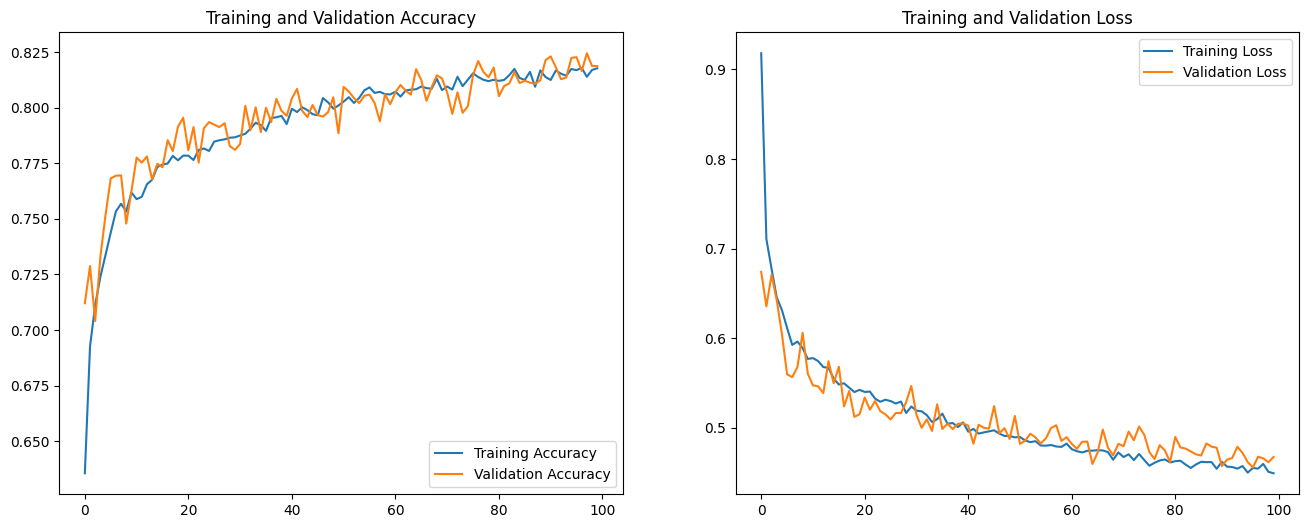

In [7]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 33s 65ms/step - loss: 1.4428 - accuracy: 0.2831 - val_loss: 1.4127 - val_accuracy: 0.2899
Epoch 2/100
360/360 [==============================] - 21s 57ms/step - loss: 1.4259 - accuracy: 0.2932 - val_loss: 1.4130 - val_accuracy: 0.3123
Epoch 3/100
360/360 [==============================] - 21s 57ms/step - loss: 1.4215 - accuracy: 0.2992 - val_loss: 1.4022 - val_accuracy: 0.2951
Epoch 4/100
360/360 [==============================] - 21s 60ms/step - loss: 1.4142 - accuracy: 0.3185 - val_loss: 1.3952 - val_accuracy: 0.4059
Epoch 5/100
360/360 [==============================] - 21s 57ms/step - loss: 1.4031 - accuracy: 0.3349 - val_loss: 1.3863 - val_accuracy: 0.2937
Epoch 6/100
360/360 [==============================] - 20s 57ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 20s 57ms/step - loss: 1.2739 - accuracy: 0.4353 - val_loss: 1.2163 - val_accuracy: 0.4957
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2704 - accuracy: 0.4392 - val_loss: 1.3219 - val_accuracy: 0.4342
Epoch 58/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2746 - accuracy: 0.4362 - val_loss: 1.2355 - val_accuracy: 0.4972
Epoch 59/100
360/360 [==============================] - 20s 57ms/step - loss: 1.2629 - accuracy: 0.4438 - val_loss: 1.2418 - val_accuracy: 0.5089
Epoch 60/100
360/360 [==============================] - 21s 57ms/step - loss: 1.2544 - accuracy: 0.4467 - val_loss: 1.2189 - val_accuracy: 0.4993
Epoch 61/100
360/360 [==============================] - 21s 57ms/step - loss: 1.2541 - accuracy: 0.4471 - val_loss: 1.1951 - val_accuracy: 0.5049
Epoch 62/100
360/360 [==============================] - 20s 57ms/step - loss: 1.2469 - accuracy: 0.4524 - val_loss: 1.2752 -

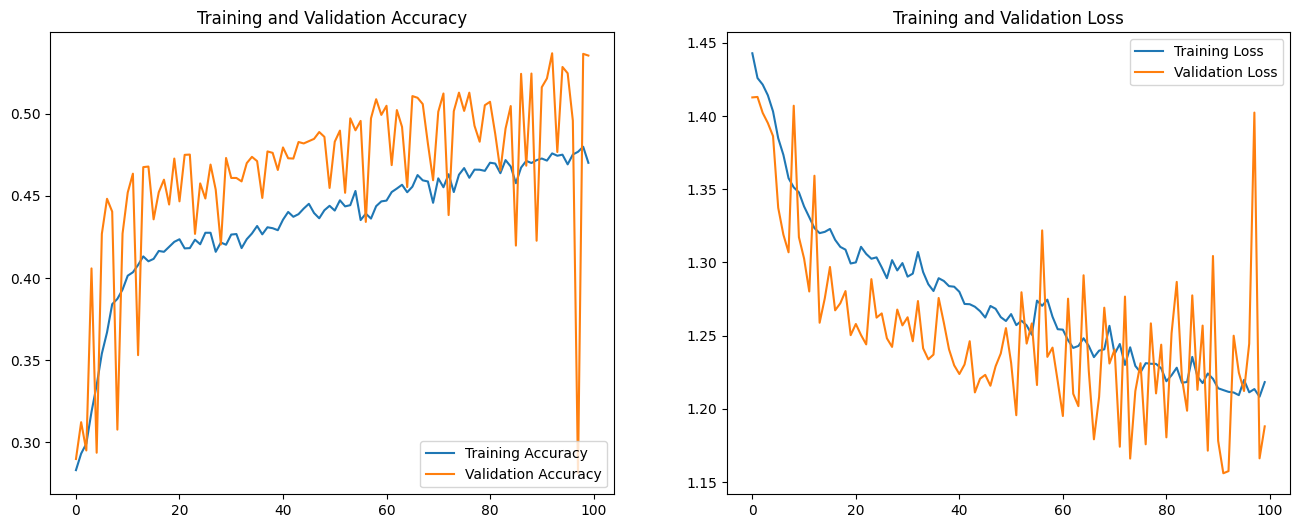

In [8]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 34s 66ms/step - loss: 0.5507 - accuracy: 0.7697 - val_loss: 0.4236 - val_accuracy: 0.8196
Epoch 2/100
360/360 [==============================] - 21s 58ms/step - loss: 0.4461 - accuracy: 0.8161 - val_loss: 0.4258 - val_accuracy: 0.8222
Epoch 3/100
360/360 [==============================] - 21s 59ms/step - loss: 0.4087 - accuracy: 0.8352 - val_loss: 0.3733 - val_accuracy: 0.8414
Epoch 4/100
360/360 [==============================] - 21s 59ms/step - loss: 0.3901 - accuracy: 0.8386 - val_loss: 0.3345 - val_accuracy: 0.8607
Epoch 5/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3732 - accuracy: 0.8495 - val_loss: 0.3425 - val_accuracy: 0.8628
Epoch 6/100
360/360 [==============================] - 21s 57ms/step - loss: 0.3591 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 20s 57ms/step - loss: 0.2647 - accuracy: 0.8938 - val_loss: 0.2591 - val_accuracy: 0.9020
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.2644 - accuracy: 0.8958 - val_loss: 0.2577 - val_accuracy: 0.9047
Epoch 58/100
360/360 [==============================] - 20s 57ms/step - loss: 0.2602 - accuracy: 0.8959 - val_loss: 0.2587 - val_accuracy: 0.9062
Epoch 59/100
360/360 [==============================] - 20s 57ms/step - loss: 0.2576 - accuracy: 0.8992 - val_loss: 0.2557 - val_accuracy: 0.9048
Epoch 60/100
360/360 [==============================] - 20s 57ms/step - loss: 0.2659 - accuracy: 0.8950 - val_loss: 0.2568 - val_accuracy: 0.9071
Epoch 61/100
360/360 [==============================] - 20s 56ms/step - loss: 0.2634 - accuracy: 0.8958 - val_loss: 0.2624 - val_accuracy: 0.8996
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.2554 - accuracy: 0.9000 - val_loss: 0.2712 -

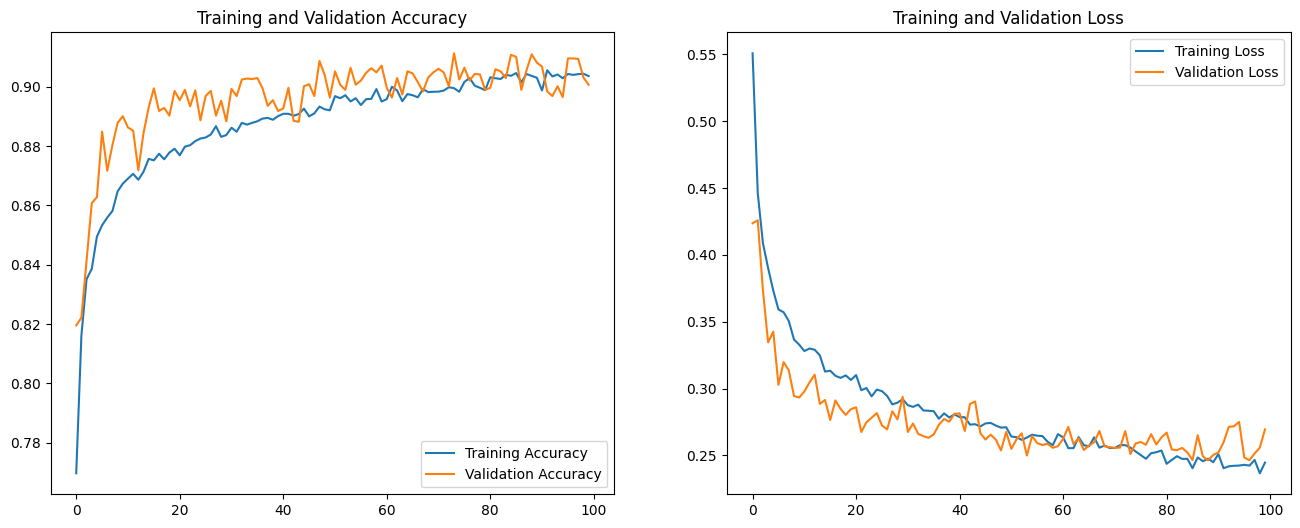

In [9]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 33s 64ms/step - loss: 1.2219 - accuracy: 0.4472 - val_loss: 1.1491 - val_accuracy: 0.4736
Epoch 2/100
360/360 [==============================] - 21s 58ms/step - loss: 1.0746 - accuracy: 0.5181 - val_loss: 0.9971 - val_accuracy: 0.5632
Epoch 3/100
360/360 [==============================] - 21s 59ms/step - loss: 1.0405 - accuracy: 0.5421 - val_loss: 0.9628 - val_accuracy: 0.5813
Epoch 4/100
360/360 [==============================] - 20s 56ms/step - loss: 1.0146 - accuracy: 0.5561 - val_loss: 0.9601 - val_accuracy: 0.5931
Epoch 5/100
360/360 [==============================] - 20s 56ms/step - loss: 0.9959 - accuracy: 0.5628 - val_loss: 0.9143 - val_accuracy: 0.5903
Epoch 6/100
360/360 [==============================] - 20s 57ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 21s 57ms/step - loss: 0.8779 - accuracy: 0.6259 - val_loss: 0.8063 - val_accuracy: 0.6613
Epoch 57/100
360/360 [==============================] - 21s 57ms/step - loss: 0.8749 - accuracy: 0.6306 - val_loss: 0.8188 - val_accuracy: 0.6594
Epoch 58/100
360/360 [==============================] - 21s 57ms/step - loss: 0.8702 - accuracy: 0.6367 - val_loss: 0.8142 - val_accuracy: 0.6540
Epoch 59/100
360/360 [==============================] - 21s 57ms/step - loss: 0.8682 - accuracy: 0.6333 - val_loss: 0.7944 - val_accuracy: 0.6671
Epoch 60/100
360/360 [==============================] - 20s 56ms/step - loss: 0.8709 - accuracy: 0.6328 - val_loss: 0.8018 - val_accuracy: 0.6700
Epoch 61/100
360/360 [==============================] - 20s 56ms/step - loss: 0.8714 - accuracy: 0.6342 - val_loss: 0.7969 - val_accuracy: 0.6671
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.8621 - accuracy: 0.6389 - val_loss: 0.7978 -

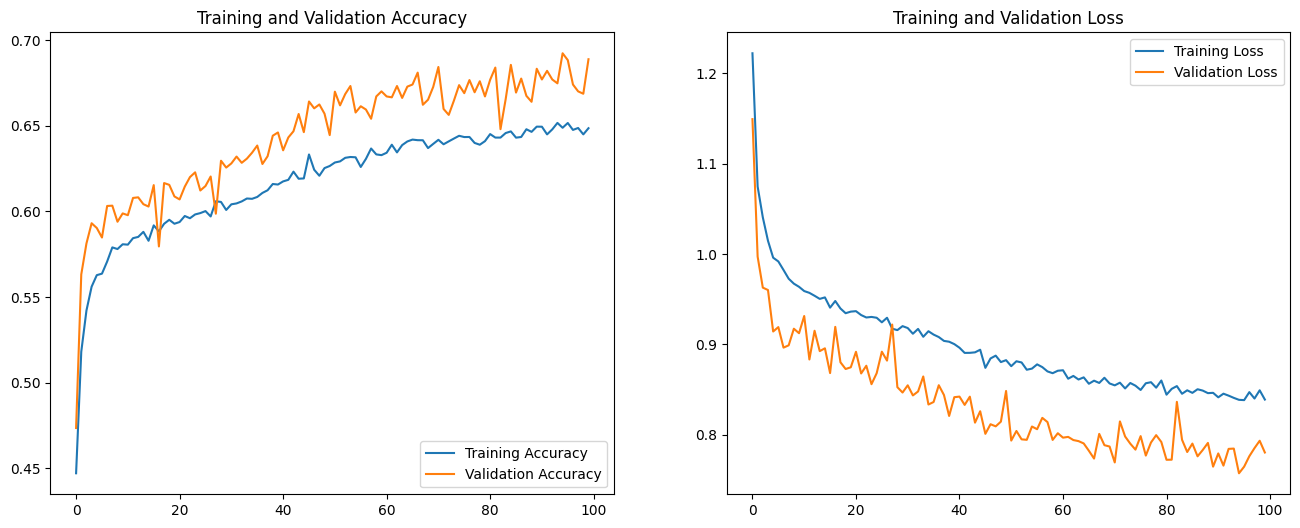

In [10]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 33s 64ms/step - loss: 0.8864 - accuracy: 0.6309 - val_loss: 0.7276 - val_accuracy: 0.6815
Epoch 2/100
360/360 [==============================] - 20s 57ms/step - loss: 0.7622 - accuracy: 0.6727 - val_loss: 0.7274 - val_accuracy: 0.6827
Epoch 3/100
360/360 [==============================] - 21s 59ms/step - loss: 0.7404 - accuracy: 0.6797 - val_loss: 0.6948 - val_accuracy: 0.6949
Epoch 4/100
360/360 [==============================] - 21s 58ms/step - loss: 0.7185 - accuracy: 0.6896 - val_loss: 0.7078 - val_accuracy: 0.6978
Epoch 5/100
360/360 [==============================] - 20s 56ms/step - loss: 0.7121 - accuracy: 0.6904 - val_loss: 0.7163 - val_accuracy: 0.6886
Epoch 6/100
360/360 [==============================] - 20s 56ms/step - loss: 0.7040 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5798 - accuracy: 0.7525 - val_loss: 0.6392 - val_accuracy: 0.7279
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5815 - accuracy: 0.7516 - val_loss: 0.6557 - val_accuracy: 0.7206
Epoch 58/100
360/360 [==============================] - 20s 57ms/step - loss: 0.5755 - accuracy: 0.7535 - val_loss: 0.6411 - val_accuracy: 0.7266
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5726 - accuracy: 0.7565 - val_loss: 0.6569 - val_accuracy: 0.7232
Epoch 60/100
360/360 [==============================] - 20s 55ms/step - loss: 0.5728 - accuracy: 0.7561 - val_loss: 0.6383 - val_accuracy: 0.7235
Epoch 61/100
360/360 [==============================] - 20s 55ms/step - loss: 0.5746 - accuracy: 0.7533 - val_loss: 0.6432 - val_accuracy: 0.7249
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5688 - accuracy: 0.7542 - val_loss: 0.6538 -

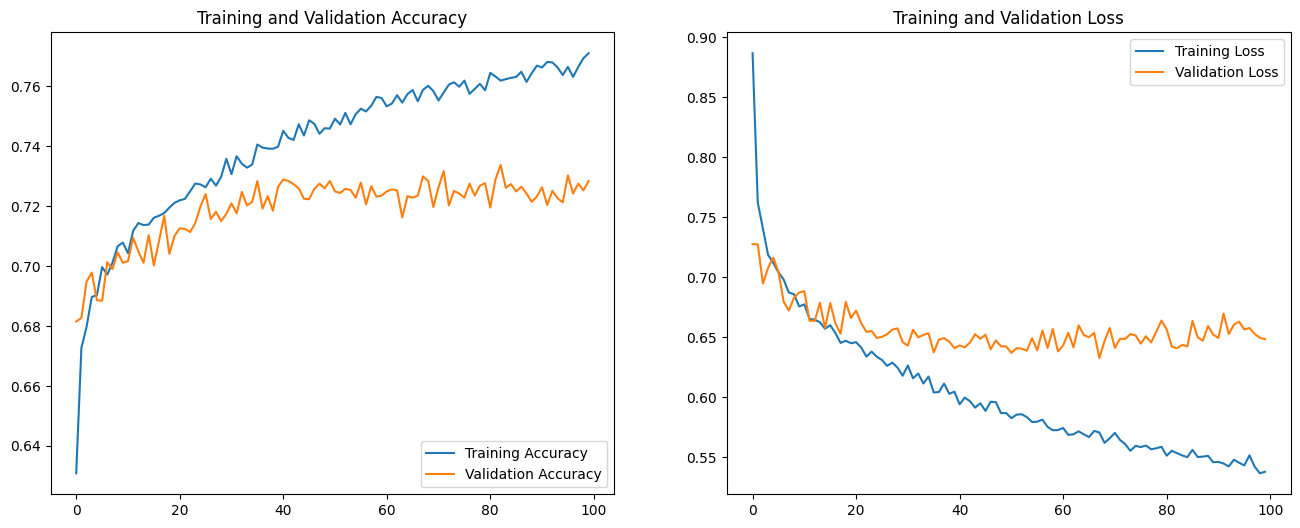

In [11]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 33s 64ms/step - loss: 1.4447 - accuracy: 0.2880 - val_loss: 1.4148 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 21s 57ms/step - loss: 1.4243 - accuracy: 0.2874 - val_loss: 1.4031 - val_accuracy: 0.3142
Epoch 3/100
360/360 [==============================] - 21s 58ms/step - loss: 1.4126 - accuracy: 0.3007 - val_loss: 1.3968 - val_accuracy: 0.3468
Epoch 4/100
360/360 [==============================] - 21s 58ms/step - loss: 1.4021 - accuracy: 0.3075 - val_loss: 1.3563 - val_accuracy: 0.3022
Epoch 5/100
360/360 [==============================] - 20s 56ms/step - loss: 1.3776 - accuracy: 0.3229 - val_loss: 1.3828 - val_accuracy: 0.3163
Epoch 6/100
360/360 [==============================] - 21s 57ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2826 - accuracy: 0.3842 - val_loss: 1.3189 - val_accuracy: 0.3684
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2761 - accuracy: 0.3875 - val_loss: 1.3219 - val_accuracy: 0.3541
Epoch 58/100
360/360 [==============================] - 20s 57ms/step - loss: 1.2630 - accuracy: 0.3961 - val_loss: 1.2236 - val_accuracy: 0.4363
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2682 - accuracy: 0.3944 - val_loss: 1.2623 - val_accuracy: 0.3791
Epoch 60/100
360/360 [==============================] - 21s 57ms/step - loss: 1.2665 - accuracy: 0.3951 - val_loss: 1.4032 - val_accuracy: 0.3140
Epoch 61/100
360/360 [==============================] - 21s 57ms/step - loss: 1.2643 - accuracy: 0.3980 - val_loss: 1.2287 - val_accuracy: 0.4119
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2641 - accuracy: 0.3933 - val_loss: 1.4384 -

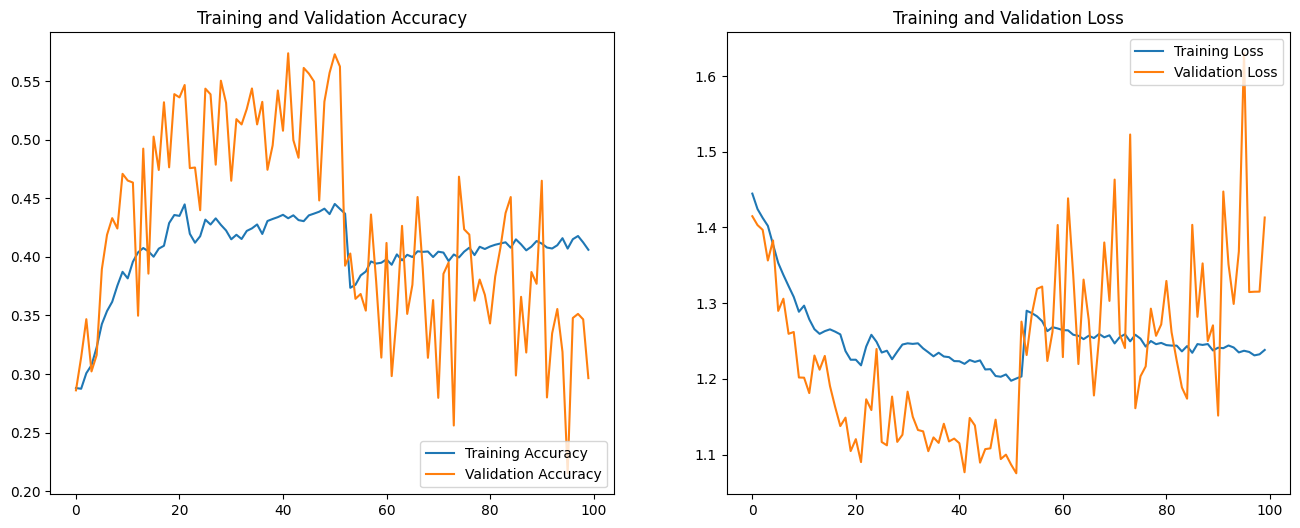

In [12]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 33s 64ms/step - loss: 0.5951 - accuracy: 0.7502 - val_loss: 0.4487 - val_accuracy: 0.8128
Epoch 2/100
360/360 [==============================] - 21s 58ms/step - loss: 0.4734 - accuracy: 0.7988 - val_loss: 0.4587 - val_accuracy: 0.8024
Epoch 3/100
360/360 [==============================] - 21s 58ms/step - loss: 0.4502 - accuracy: 0.8116 - val_loss: 0.4012 - val_accuracy: 0.8366
Epoch 4/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4332 - accuracy: 0.8214 - val_loss: 0.4009 - val_accuracy: 0.8371
Epoch 5/100
360/360 [==============================] - 20s 57ms/step - loss: 0.4243 - accuracy: 0.8247 - val_loss: 0.3934 - val_accuracy: 0.8381
Epoch 6/100
360/360 [==============================] - 20s 57ms/step - loss: 0.4092 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3073 - accuracy: 0.8744 - val_loss: 0.2996 - val_accuracy: 0.8868
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3081 - accuracy: 0.8778 - val_loss: 0.2972 - val_accuracy: 0.8793
Epoch 58/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3036 - accuracy: 0.8807 - val_loss: 0.2895 - val_accuracy: 0.8876
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3038 - accuracy: 0.8768 - val_loss: 0.3128 - val_accuracy: 0.8743
Epoch 60/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3018 - accuracy: 0.8784 - val_loss: 0.2952 - val_accuracy: 0.8859
Epoch 61/100
360/360 [==============================] - 20s 57ms/step - loss: 0.3020 - accuracy: 0.8799 - val_loss: 0.2853 - val_accuracy: 0.8875
Epoch 62/100
360/360 [==============================] - 20s 57ms/step - loss: 0.3046 - accuracy: 0.8775 - val_loss: 0.2882 -

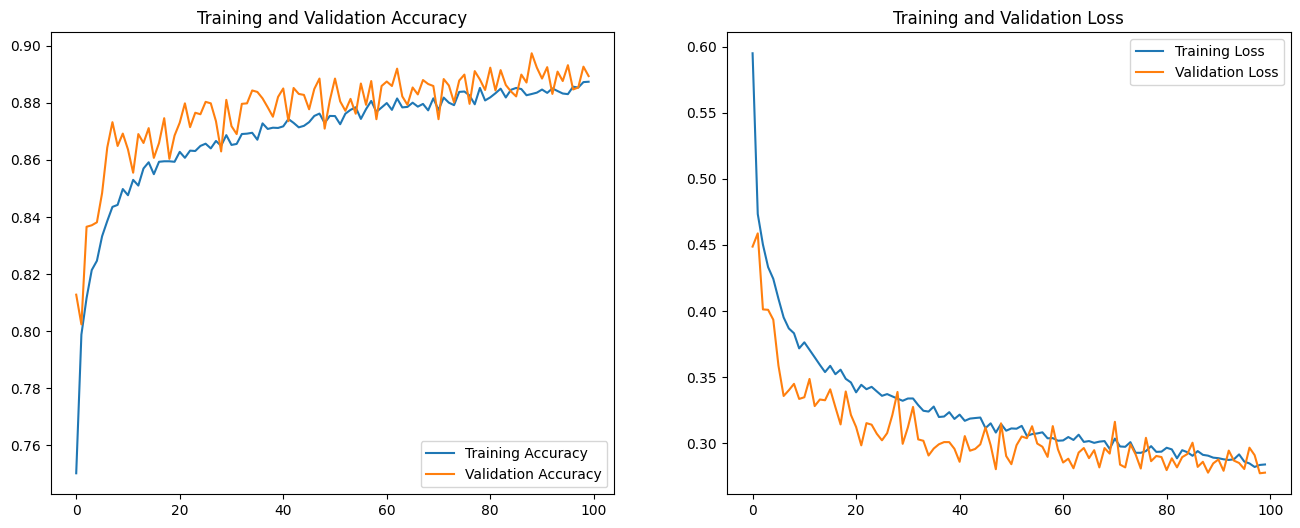

In [13]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 34s 66ms/step - loss: 1.4380 - accuracy: 0.2915 - val_loss: 1.3956 - val_accuracy: 0.4528
Epoch 2/100
360/360 [==============================] - 21s 58ms/step - loss: 1.4006 - accuracy: 0.3305 - val_loss: 1.4000 - val_accuracy: 0.2890
Epoch 3/100
360/360 [==============================] - 21s 59ms/step - loss: 1.3586 - accuracy: 0.3680 - val_loss: 1.2935 - val_accuracy: 0.4024
Epoch 4/100
360/360 [==============================] - 21s 59ms/step - loss: 1.2965 - accuracy: 0.4095 - val_loss: 1.3388 - val_accuracy: 0.3800
Epoch 5/100
360/360 [==============================] - 21s 57ms/step - loss: 1.2568 - accuracy: 0.4329 - val_loss: 1.1427 - val_accuracy: 0.5243
Epoch 6/100
360/360 [==============================] - 21s 57ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 20s 57ms/step - loss: 1.0941 - accuracy: 0.5189 - val_loss: 0.9768 - val_accuracy: 0.5881
Epoch 57/100
360/360 [==============================] - 20s 57ms/step - loss: 1.0919 - accuracy: 0.5203 - val_loss: 1.0082 - val_accuracy: 0.5722
Epoch 58/100
360/360 [==============================] - 22s 60ms/step - loss: 1.0764 - accuracy: 0.5292 - val_loss: 0.9714 - val_accuracy: 0.5966
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 1.0805 - accuracy: 0.5268 - val_loss: 1.0057 - val_accuracy: 0.5587
Epoch 60/100
360/360 [==============================] - 20s 56ms/step - loss: 1.0763 - accuracy: 0.5262 - val_loss: 1.0113 - val_accuracy: 0.5594
Epoch 61/100
360/360 [==============================] - 20s 57ms/step - loss: 1.0906 - accuracy: 0.5202 - val_loss: 0.9905 - val_accuracy: 0.5934
Epoch 62/100
360/360 [==============================] - 20s 57ms/step - loss: 1.0896 - accuracy: 0.5196 - val_loss: 0.9839 -

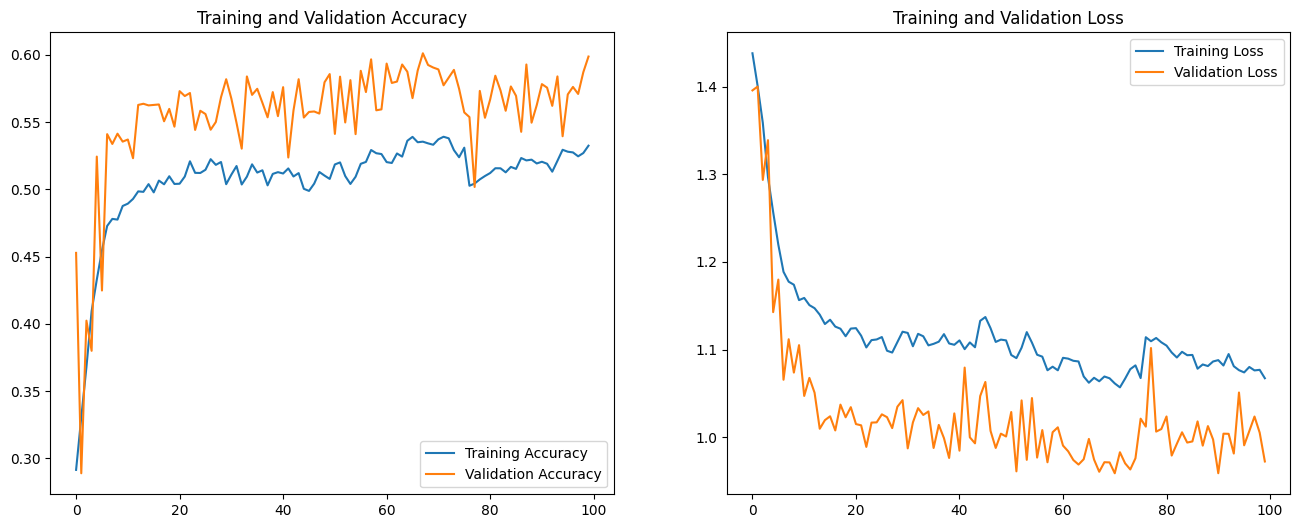

In [14]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 35s 65ms/step - loss: 0.7484 - accuracy: 0.6775 - val_loss: 0.5915 - val_accuracy: 0.7348
Epoch 2/100
360/360 [==============================] - 20s 57ms/step - loss: 0.6268 - accuracy: 0.7258 - val_loss: 0.5694 - val_accuracy: 0.7480
Epoch 3/100
360/360 [==============================] - 20s 57ms/step - loss: 0.6049 - accuracy: 0.7374 - val_loss: 0.5851 - val_accuracy: 0.7345
Epoch 4/100
360/360 [==============================] - 21s 58ms/step - loss: 0.5841 - accuracy: 0.7465 - val_loss: 0.5583 - val_accuracy: 0.7470
Epoch 5/100
360/360 [==============================] - 22s 63ms/step - loss: 0.5763 - accuracy: 0.7494 - val_loss: 0.5420 - val_accuracy: 0.7598
Epoch 6/100
360/360 [==============================] - 21s 58ms/step - loss: 0.5688 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 20s 55ms/step - loss: 0.4355 - accuracy: 0.8182 - val_loss: 0.4693 - val_accuracy: 0.8081
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4405 - accuracy: 0.8161 - val_loss: 0.4671 - val_accuracy: 0.8114
Epoch 58/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4359 - accuracy: 0.8192 - val_loss: 0.4731 - val_accuracy: 0.8024
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4349 - accuracy: 0.8167 - val_loss: 0.4860 - val_accuracy: 0.7954
Epoch 60/100
360/360 [==============================] - 20s 57ms/step - loss: 0.4375 - accuracy: 0.8177 - val_loss: 0.4688 - val_accuracy: 0.8071
Epoch 61/100
360/360 [==============================] - 21s 57ms/step - loss: 0.4400 - accuracy: 0.8141 - val_loss: 0.4706 - val_accuracy: 0.8005
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4388 - accuracy: 0.8155 - val_loss: 0.4574 -

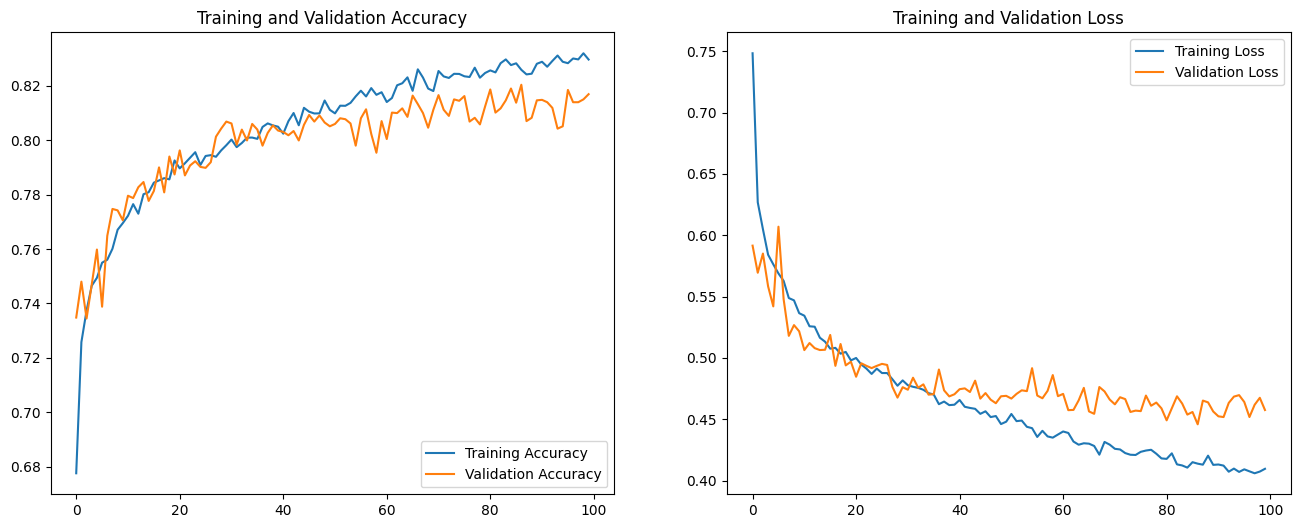

In [15]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [24]:
# !mkdir densenet201_nontrainable
# pd.DataFrame(res_rgb).to_csv("densenet201_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("densenet201_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("densenet201_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("densenet201_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("densenet201_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("densenet201_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("densenet201_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("densenet201_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("densenet201_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("densenet201_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("densenet201_nontrainable/res_ydbdr_nonpre.csv", index=False)